In [1]:
import os
import pickle
import pathlib

import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from tensorflow.python.platform import gfile

import input_data

import IPython.display as ipd
from scipy.io import wavfile

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
sns.set()
sns.set_palette("bright")
# sns.set(font_scale=1)

# Model Definition

In [12]:
# mobilenet/resnet
input_shape = (49,40,1)
num_labels=len(a.commands) # will include silence/unknown

base_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights=None, #"imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling=None
    #classes=1000,
    #classifier_activation="softmax",
)
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
#layers.Dropout(0.5)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(128, kernel_initializer='lecun_normal', activation='selu')(x)
# must use alpha-dropout if dropout is desired with selu
logits = layers.Dense(num_labels)(x)

model = models.Model(inputs=base_model.input, outputs=logits)

model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(), #learning_rate=0.001
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 49, 40, 1)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 55, 46, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 25, 20, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 27, 22, 64)   0           conv1_conv[0][0]                 
_______________________________________________________________________________________

# zero-shot and few-shot analysis

In [83]:
data_dir = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/"
os.chdir("/home/mark/tinyspeech_harvard/train_100_augment/")
with open("wordlist.txt", "r") as fh:
    commands = fh.read().splitlines()
with open("files.txt", "r") as fh:
    files = fh.read().splitlines()    
    
ten_pct = int(0.1 * len(files))
train_split = ten_pct * 8 
val_split = train_split + ten_pct

train_files = files[:train_split]
val_files = files[train_split:val_split]
test_files = files[val_split:]

print(len(train_files), len(val_files), len(test_files))    
model_settings = input_data.prepare_model_settings(
        label_count=100,
        sample_rate=16000,
        clip_duration_ms=1000,
        window_size_ms=30,
        window_stride_ms=20,
        feature_bin_count=40,
        preprocess="micro",
    )
bg_datadir = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/_background_noise_/"

a = input_data.AudioDataset(model_settings, commands, bg_datadir, [], unknown_percentage=0)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = a.init(AUTOTUNE, train_files, is_training=True)
val_ds = a.init(AUTOTUNE, val_files, is_training=False)
test_ds = a.init(AUTOTUNE, test_files, is_training=False)
batch_size = 64
train_ds = train_ds.shuffle(buffer_size=4000).batch(batch_size)
val_ds = val_ds.batch(batch_size)

160000 20000 20000


In [5]:
model = tf.keras.models.load_model("./hundredword_resnet_2k_selu.48-0.87")

penultimate = tf.keras.Model(inputs=model.inputs, outputs=model.get_layer("dense_21").output)

In [6]:
test_audio = []
test_labels = []

for ix,(audio, label) in enumerate(test_ds):
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())
    if ix % 6000 == 0:
        print(ix)
    #if ix > 8000:
    #    break

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

0
6000
12000
18000
Test set accuracy: 87%


In [7]:
other_words = [w for w in os.listdir(data_dir) if w != "_background_noise_" and w not in commands]
other_words.sort()
print(len(other_words))
assert(len(set(other_words).intersection(commands))==0)

165


In [84]:
def to_embedding(file_path):
    spectrogram = a.file2spec(file_path, add_bg=False)
    spectrogram = spectrogram.numpy().reshape(1,49,40,1)
    embedding = penultimate.predict(spectrogram)
    return np.squeeze(embedding)

In [9]:
def to_embeddings_vectorized(file_paths):
    spectrograms = [a.file2spec(f, add_bg=False) for f in file_paths]
    spectrograms = [s.numpy().reshape(1,49,40,1) for s in spectrograms]
    spectrograms = np.concatenate(spectrograms)
    embeddings = penultimate.predict(spectrograms)
    return embeddings

In [8]:
candidate_word="appeared"
target = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/appeared/common_voice_en_20522625.wav"

In [ ]:
candidates = glob.glob(f"{data_dir}{candidate_word}/*.wav")
print(candidate_word, target)
NUM_SAMPLES=200
samples = np.random.choice(candidates, NUM_SAMPLES, replace=False)
samples = [s for s in samples if s != target]

distances_to_target=[]
target_embedding = to_embedding(target)
for ix,w in enumerate(samples):
    e = to_embedding(w)
    d = np.linalg.norm(target_embedding - e)
    distances_to_target.append(d)

values, bins, _ = plt.hist(distances_to_target,bins=50);    

In [85]:
e = to_embedding("/home/mark/tinyspeech_harvard/frequent_words/en/clips/national/common_voice_en_22251317.wav")
f = to_embedding("/home/mark/tinyspeech_harvard/frequent_words/en/clips/national/common_voice_en_19009678.wav")

In [86]:
np.linalg.norm(e-f)

5.145691

# few-shot target words selected blindly

broadcasting scratch notes for vectorizing few-shot embeddings

In [142]:
gs = np.random.rand(3,4) * 100 # 3 candidate embeddings of len 4
hs = np.random.rand(2,4) * 100 # 2-shot embedding vectors of len 4
gs = np.round(gs)
hs = np.round(hs)
print(gs)
print(hs)
print("--")

print(gs[:,np.newaxis,:].shape)
print("--")

# 3x2x4: 3 candidate embeddings - each of the 2-shot embedding vectors
# gs[0] - hs[0] is res[0][0] (len:4)
# gs[0] - hs[1] is res[0][1] (len:4)
res = gs[:,np.newaxis,:] - hs 
print("result")
print(res)
print(res.shape)
print("--")

print(gs[1] - hs[0])
print(gs[1] - hs[1])
print("--")

n = np.linalg.norm(res,axis=2)
print(n)
print(n.shape)
fst = np.linalg.norm(gs[1] - hs[0])
snd = np.linalg.norm(gs[1] - hs[1])
print(fst,snd)

print(np.amin(n,axis=1))

[[91. 26. 96. 76.]
 [41. 10. 90. 36.]
 [ 1. 44. 64. 75.]]
[[22. 12. 32.  2.]
 [69. 69.  2. 61.]]
--
(3, 1, 4)
--
result
[[[ 69.  14.  64.  74.]
  [ 22. -43.  94.  15.]]

 [[ 19.  -2.  58.  34.]
  [-28. -59.  88. -25.]]

 [[-21.  32.  32.  73.]
  [-68. -25.  62.  14.]]]
(3, 2, 4)
--
[19. -2. 58. 34.]
[-28. -59.  88. -25.]
--
[[120.53630159 106.74268125]
 [ 69.89277502 112.40106761]
 [ 88.41945487  96.37945839]]
(3, 2)
69.8927750200262 112.40106761058811
[106.74268125  69.89277502  88.41945487]


near
earth
looking
public
named
eight
look
new
between


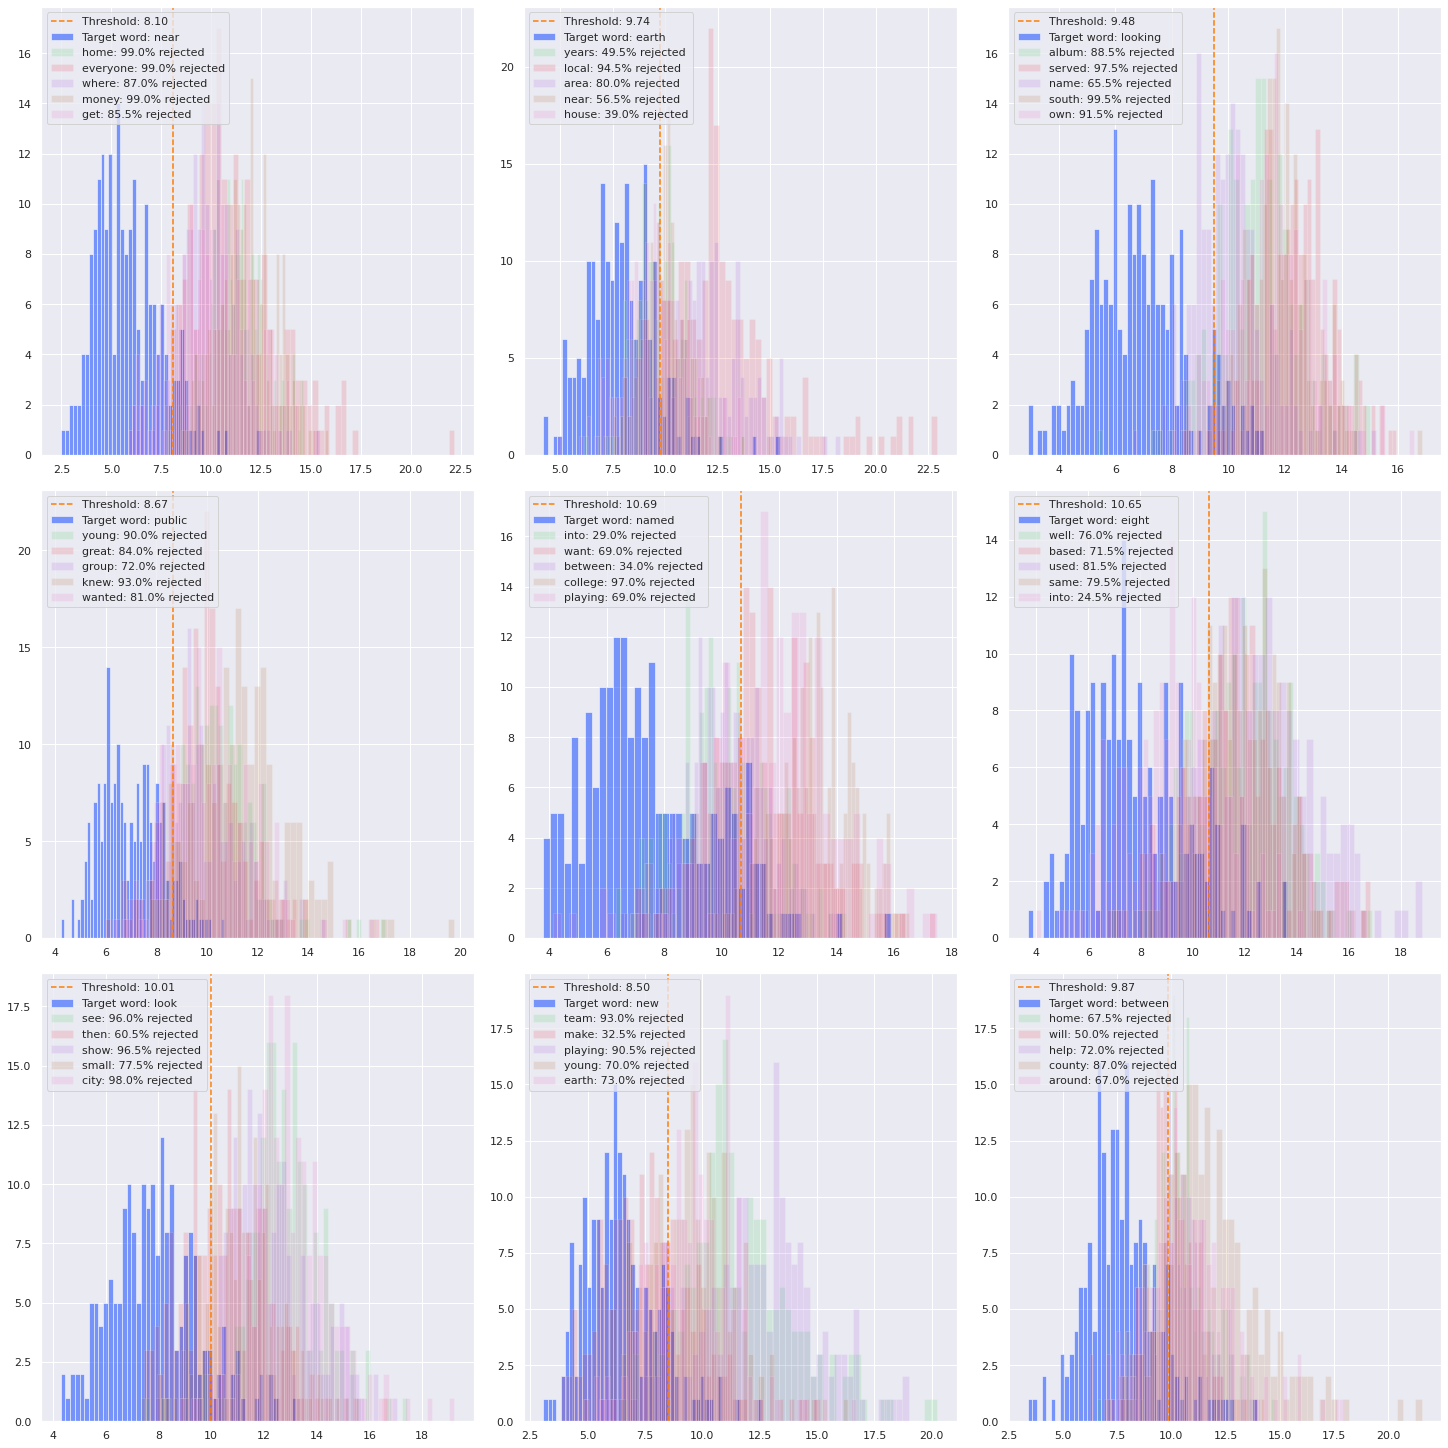

In [9]:
NUM_SAMPLES=200
THRESH = 0.9
NON_TARGET_WORDS = 5
FEW_SHOT = 5

NUM_WORDS =9
nrows,ncols = 3,3
fig,axes= plt.subplots(nrows=nrows,ncols=ncols,constrained_layout=True)
assert nrows * ncols == NUM_WORDS

def min_distance_to_embeddings(target_embeddings, file_paths):
    e = to_embedding(file_path)
    es = to_embeddings_vectorized(file_paths)
    distances = np.linalg.norm(target_embeddings - e, axis=1)
    return np.amin(distances)

def vectorized_min_distances_to_few_shot_embeddings(target_embeddings, file_paths):
    candidate_embeddings = to_embeddings_vectorized(file_paths)
    # n_candidate_embeddings x 1 x embedding_width
    candidate_embeddings = candidate_embeddings[:,np.newaxis,:]
    # n_candidate_embeddings x m_target_embeddings x embedding_width
    a_to_b = candidate_embeddings - target_embeddings

    # n_candidate_embeddings x m_target_embeddings
    distances = np.linalg.norm(a_to_b, axis=2)
    return np.amin(distances,axis=1)

candidate_words = np.random.choice(other_words, NUM_WORDS, replace=False)
for ix,candidate_word in enumerate(candidate_words):
    row = ix // nrows
    col = ix % ncols
    ax = axes[row][col]
    print(candidate_word)
    
    candidates = glob.glob(f"{data_dir}{candidate_word}/*.wav")
    samples = np.random.choice(candidates, NUM_SAMPLES + FEW_SHOT, replace=False)

    targets = samples[:FEW_SHOT]
    additional_samples = samples[FEW_SHOT:]

    target_embeddings = to_embeddings_vectorized(targets) 
    #distances = [min_distance_to_embeddings(target_embeddings, f) for f in additional_samples]
    distances = vectorized_min_distances_to_few_shot_embeddings(target_embeddings, additional_samples)
    
    threshold = np.quantile(distances, THRESH)
    
    non_target_words = np.random.choice(other_words, NON_TARGET_WORDS + 1, replace=False)
    non_target_words = [w for w in non_target_words if w != candidate_word][:NON_TARGET_WORDS]
    
    # target distance distribution
    ax.hist(distances, bins=50, alpha=0.5, label=f"Target word: {candidate_word}", color=sns.color_palette("bright")[0]);
    # target threshold
    ax.axvline(x=threshold, label=f"Threshold: {threshold:.2f}", linestyle="--", color=sns.color_palette("bright")[1])
    
    for jx, w in enumerate(non_target_words):
        non_target_candidates = glob.glob(f"{data_dir}{w}/*.wav")
        non_target_samples = np.random.choice(non_target_candidates, NUM_SAMPLES, replace=False)
        non_target_distances = vectorized_min_distances_to_few_shot_embeddings(target_embeddings, non_target_samples)
        
        correct_rejected_pct = (non_target_distances[non_target_distances > threshold].shape[0] / NUM_SAMPLES) * 100
        
        ax.hist(non_target_distances, bins=50, alpha=0.125, label=f"{w}: {correct_rejected_pct:.1f}% rejected", color=sns.color_palette("bright")[jx + 2]);        
   
    ax.legend(loc='upper left');    
fig.set_size_inches(20,20);

## presentation

get


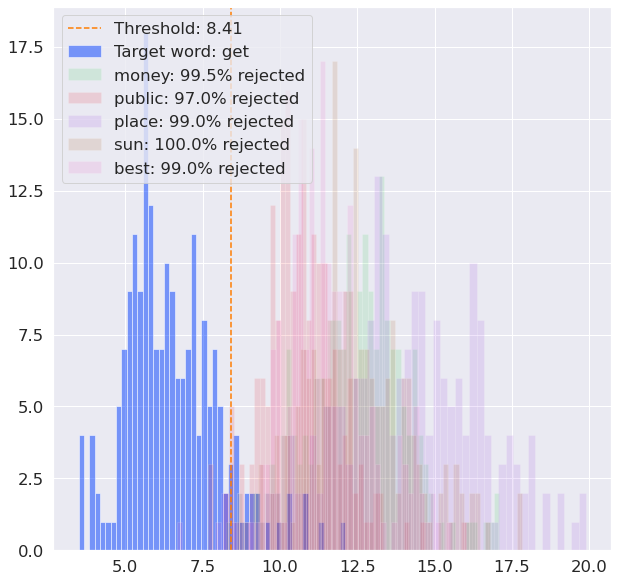

In [59]:
NUM_SAMPLES=200
THRESH = 0.9
NON_TARGET_WORDS = 5
FEW_SHOT = 5

NUM_WORDS =9

fig,ax= plt.subplots()


def min_distance_to_embeddings(target_embeddings, file_paths):
    e = to_embedding(file_path)
    es = to_embeddings_vectorized(file_paths)
    distances = np.linalg.norm(target_embeddings - e, axis=1)
    return np.amin(distances)

def vectorized_min_distances_to_few_shot_embeddings(target_embeddings, file_paths):
    candidate_embeddings = to_embeddings_vectorized(file_paths)
    # n_candidate_embeddings x 1 x embedding_width
    candidate_embeddings = candidate_embeddings[:,np.newaxis,:]
    # n_candidate_embeddings x m_target_embeddings x embedding_width
    a_to_b = candidate_embeddings - target_embeddings

    # n_candidate_embeddings x m_target_embeddings
    distances = np.linalg.norm(a_to_b, axis=2)
    return np.amin(distances,axis=1)

candidate_word = np.random.choice(other_words)
#candidate_word = "river"
print(candidate_word)

candidates = glob.glob(f"{data_dir}{candidate_word}/*.wav")
samples = np.random.choice(candidates, NUM_SAMPLES + FEW_SHOT, replace=False)

targets = samples[:FEW_SHOT]
additional_samples = samples[FEW_SHOT:]

target_embeddings = to_embeddings_vectorized(targets) 
#distances = [min_distance_to_embeddings(target_embeddings, f) for f in additional_samples]
distances = vectorized_min_distances_to_few_shot_embeddings(target_embeddings, additional_samples)

threshold = np.quantile(distances, THRESH)

non_target_words = np.random.choice(other_words, NON_TARGET_WORDS + 1, replace=False)
non_target_words = [w for w in non_target_words if w != candidate_word][:NON_TARGET_WORDS]
#non_target_words = ["desert", "make", "could", "need", "five"]

# target distance distribution
ax.hist(distances, bins=50, alpha=0.5, label=f"Target word: {candidate_word}", color=sns.color_palette("bright")[0]);
# target threshold
ax.axvline(x=threshold, label=f"Threshold: {threshold:.2f}", linestyle="--", color=sns.color_palette("bright")[1])

for jx, w in enumerate(non_target_words):
    non_target_candidates = glob.glob(f"{data_dir}{w}/*.wav")
    non_target_samples = np.random.choice(non_target_candidates, NUM_SAMPLES, replace=False)
    non_target_distances = vectorized_min_distances_to_few_shot_embeddings(target_embeddings, non_target_samples)

    correct_rejected_pct = (non_target_distances[non_target_distances > threshold].shape[0] / NUM_SAMPLES) * 100

    ax.hist(non_target_distances, bins=50, alpha=0.125, label=f"{w}: {correct_rejected_pct:.1f}% rejected", color=sns.color_palette("bright")[jx + 2]);        

ax.legend(loc='upper left');    
fig.set_size_inches(10,10);

# zero-shot, but first listening to each target keyword

In [10]:
NUM_WORDS =9
candidate_words = np.random.choice(other_words, NUM_WORDS, replace=False)
print(candidate_words)

['going' 'office' 'wind' 'water' 'work' 'team' 'playing' 'day' 'home']


In [11]:
candidate_targets = [None for _ in range(NUM_WORDS)]

In [12]:
ix = 7
candidates = glob.glob(f"{data_dir}{candidate_words[ix]}/*.wav")
target = np.random.choice(candidates)
print(target)
ipd.Audio(target, autoplay=True)

/home/mark/tinyspeech_harvard/frequent_words/en/clips/day/common_voice_en_17481753.wav


In [256]:
candidate_targets[ix] = target
candidate_targets

['/home/mark/tinyspeech_harvard/frequent_words/en/clips/building/common_voice_en_22037116.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/river/common_voice_en_18834695.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/find/common_voice_en_18473991.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/several/common_voice_en_19010622.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/most/common_voice_en_20582597.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/high/common_voice_en_21475412.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/looking/common_voice_en_492603.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/around/common_voice_en_18355828.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/such/common_voice_en_19737650.wav']

In [257]:
raise ValueError("caution:overwrites")
with open("candidate_targets_9.txt",'w') as fh:
    fh.write("\n".join(candidate_targets))

In [13]:
with open("candidate_targets_9.txt", 'r') as fh:
    candidate_targets = fh.read().splitlines()

In [14]:
candidate_targets

['/home/mark/tinyspeech_harvard/frequent_words/en/clips/building/common_voice_en_22037116.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/river/common_voice_en_18834695.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/find/common_voice_en_18473991.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/several/common_voice_en_19010622.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/most/common_voice_en_20582597.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/high/common_voice_en_21475412.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/looking/common_voice_en_492603.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/around/common_voice_en_18355828.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/such/common_voice_en_19737650.wav']

In [258]:
ix=7
ipd.Audio(candidate_targets[ix], autoplay=True)

building
river
find
several
most
high
looking
around
such


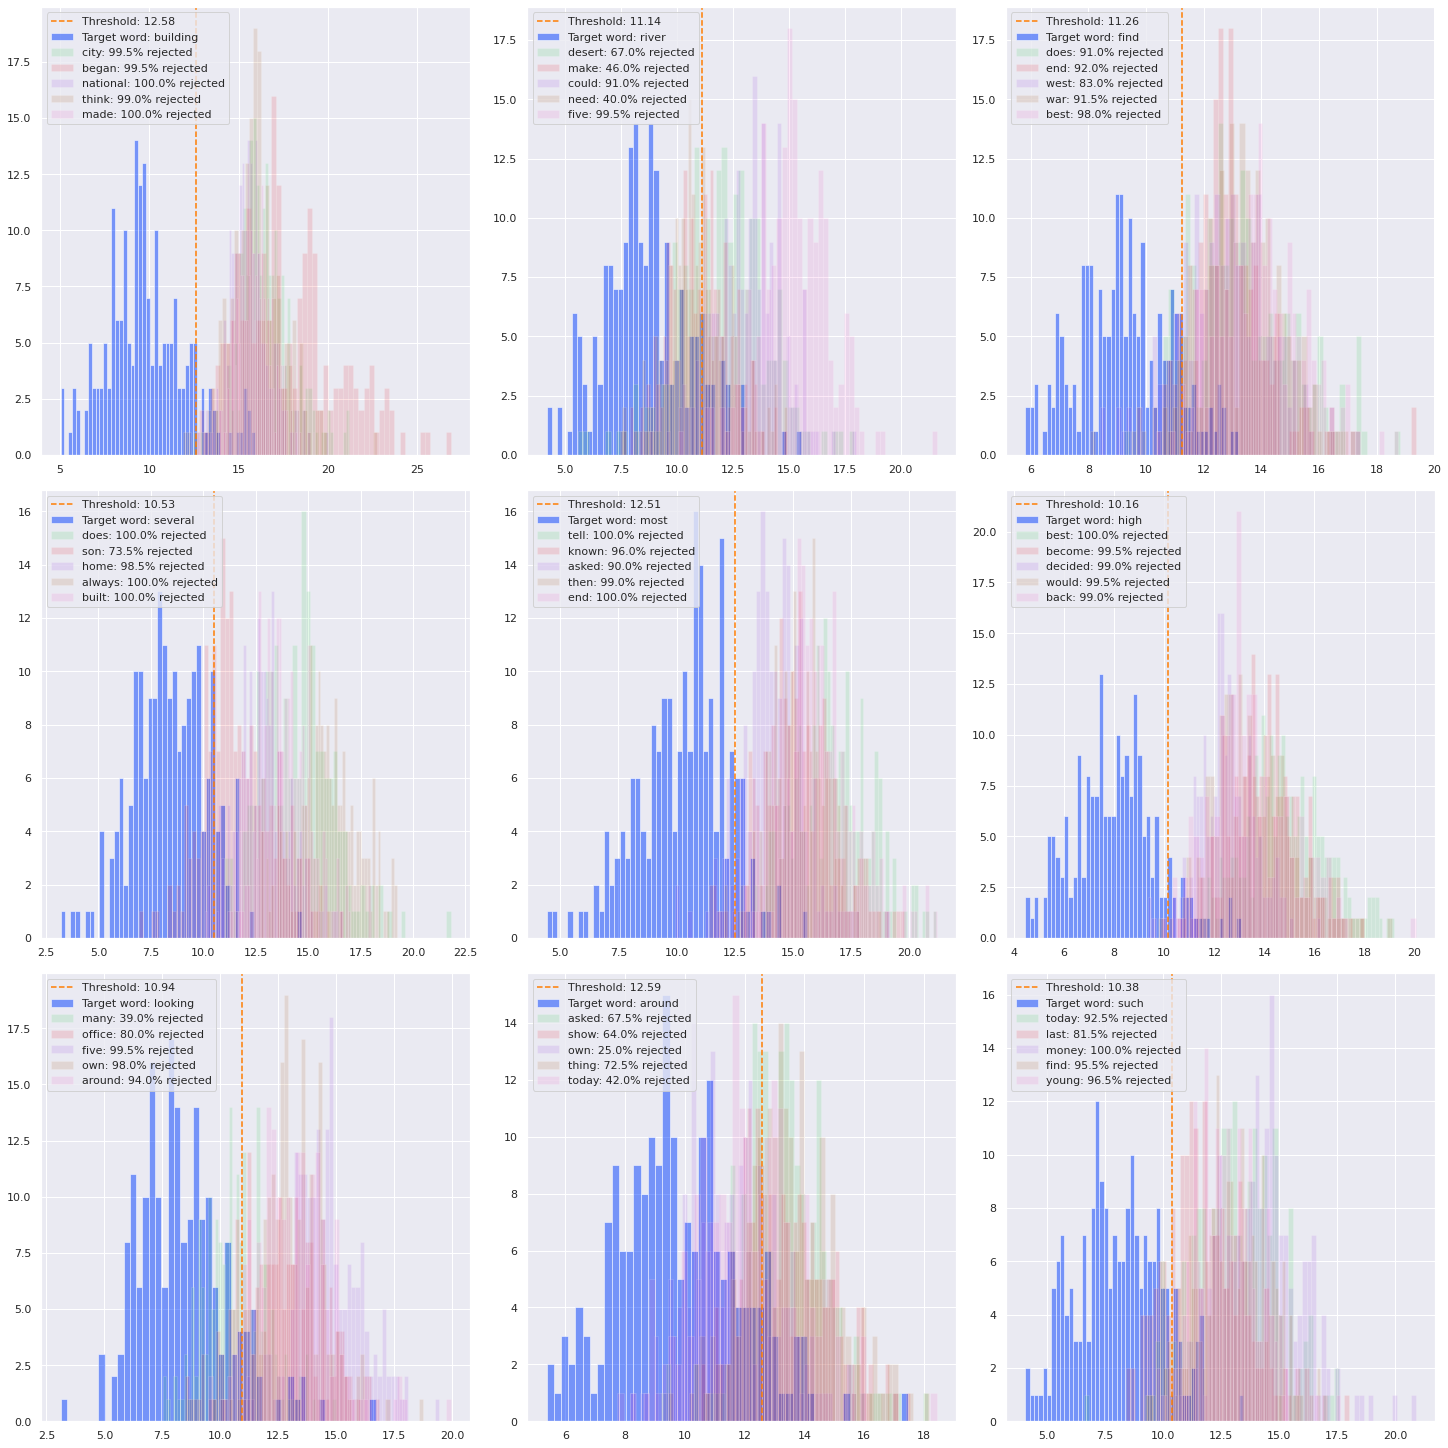

In [87]:
NUM_SAMPLES=200
THRESH = 0.90
NON_TARGET_WORDS = 5

NUM_WORDS =len(candidate_targets)
nrows,ncols = 3,3
#fig,axes= plt.subplots(nrows=nrows,ncols=ncols, gridspec_kw = {'wspace':0, 'hspace':0})
fig,axes= plt.subplots(nrows=nrows,ncols=ncols, constrained_layout=True)
assert nrows * ncols == NUM_WORDS

for ix,candidate_target in enumerate(candidate_targets):
    row = ix // nrows
    col = ix % ncols
    ax = axes[row][col]
    
    candidate_word = candidate_target.split("/")[-2]
    print(candidate_word)
    candidates = glob.glob(f"{data_dir}{candidate_word}/*.wav")
    samples = np.random.choice(candidates, NUM_SAMPLES + 1, replace=False)
    samples = [w for w in samples if w != candidate_target][:NUM_SAMPLES]

    target_embedding = to_embedding(candidate_target)
    distances = np.linalg.norm(to_embeddings_vectorized(samples) - target_embedding, axis=1)
    
    threshold = np.quantile(distances, THRESH)
    
    non_target_words = np.random.choice(other_words, NON_TARGET_WORDS + 1, replace=False)
    non_target_words = [w for w in non_target_words if w != candidate_word][:NON_TARGET_WORDS]
    
    # target distance distribution
    ax.hist(distances, bins=50, alpha=0.5, label=f"Target word: {candidate_word}", color=sns.color_palette("bright")[0]);
    # target threshold
    ax.axvline(x=threshold, label=f"Threshold: {threshold:.2f}", linestyle="--", color=sns.color_palette("bright")[1])
    
    for jx, w in enumerate(non_target_words):
        non_target_candidates = glob.glob(f"{data_dir}{w}/*.wav")
        non_target_samples = np.random.choice(non_target_candidates, NUM_SAMPLES, replace=False)
        non_target_distances = np.linalg.norm(to_embeddings_vectorized(non_target_samples) - target_embedding, axis=1)
        
        correct_rejected_pct = (non_target_distances[non_target_distances > threshold].shape[0] / NUM_SAMPLES) * 100
        
        ax.hist(non_target_distances, bins=50, alpha=0.125, label=f"{w}: {correct_rejected_pct:.1f}% rejected", color=sns.color_palette("bright")[jx + 2]);        
   
    ax.legend(loc='upper left');

fig.set_size_inches(20,20);

## presentation

In [19]:
sns.set(font_scale=1.5)

In [29]:
ax.get_ylim(), ax.get_xlim()

((0.0, 15.75), (4.238244533538818, 22.57118272781372))

river


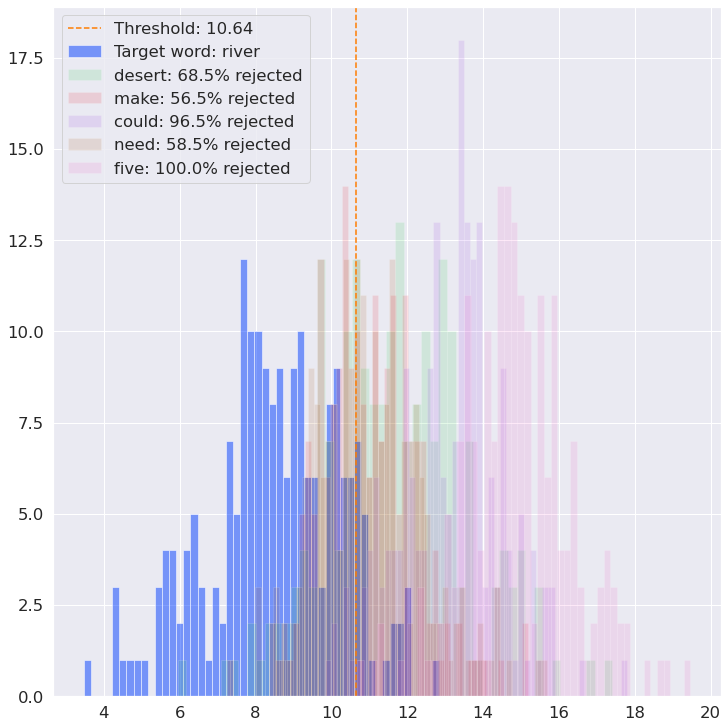

In [45]:
NUM_SAMPLES=200
THRESH = 0.90
NON_TARGET_WORDS = 5

#NUM_WORDS =len(candidate_targets)

fig,ax= plt.subplots(constrained_layout=True)

candidate_target=candidate_targets[1]
    
candidate_word = candidate_target.split("/")[-2]
print(candidate_word)
candidates = glob.glob(f"{data_dir}{candidate_word}/*.wav")
samples = np.random.choice(candidates, NUM_SAMPLES + 1, replace=False)
samples = [w for w in samples if w != candidate_target][:NUM_SAMPLES]

target_embedding = to_embedding(candidate_target)
distances = np.linalg.norm(to_embeddings_vectorized(samples) - target_embedding, axis=1)

threshold = np.quantile(distances, THRESH)

# non_target_words = np.random.choice(other_words, NON_TARGET_WORDS + 1, replace=False)
# non_target_words = [w for w in non_target_words if w != candidate_word][:NON_TARGET_WORDS]

#non_target_words = ["help", "just", "looked", "need", "work"]
non_target_words = ["desert", "make", "could", "need", "five"]
#non_target_words = non_target_words[:0]

# target distance distribution
ax.hist(distances, bins=50, alpha=0.5, label=f"Target word: {candidate_word}", color=sns.color_palette("bright")[0]);
# target threshold
ax.axvline(x=threshold, label=f"Threshold: {threshold:.2f}", linestyle="--", color=sns.color_palette("bright")[1])

ds = {}

for jx, w in enumerate(non_target_words):
    non_target_candidates = glob.glob(f"{data_dir}{w}/*.wav")
    non_target_samples = np.random.choice(non_target_candidates, NUM_SAMPLES, replace=False)
    non_target_distances = np.linalg.norm(to_embeddings_vectorized(non_target_samples) - target_embedding, axis=1)

    correct_rejected_pct = (non_target_distances[non_target_distances > threshold].shape[0] / NUM_SAMPLES) * 100

    ax.hist(non_target_distances, bins=50, alpha=0.125, label=f"{w}: {correct_rejected_pct:.1f}% rejected", color=sns.color_palette("bright")[jx + 2]);        
    ds[w] = (non_target_distances, correct_rejected_pct)
ax.legend(loc='upper left');
#ax.set_ylim((0.0, 21.0))
#ax.set_xlim((3.965904188156128, 22.584151315689088))
fig.set_size_inches(10,10);

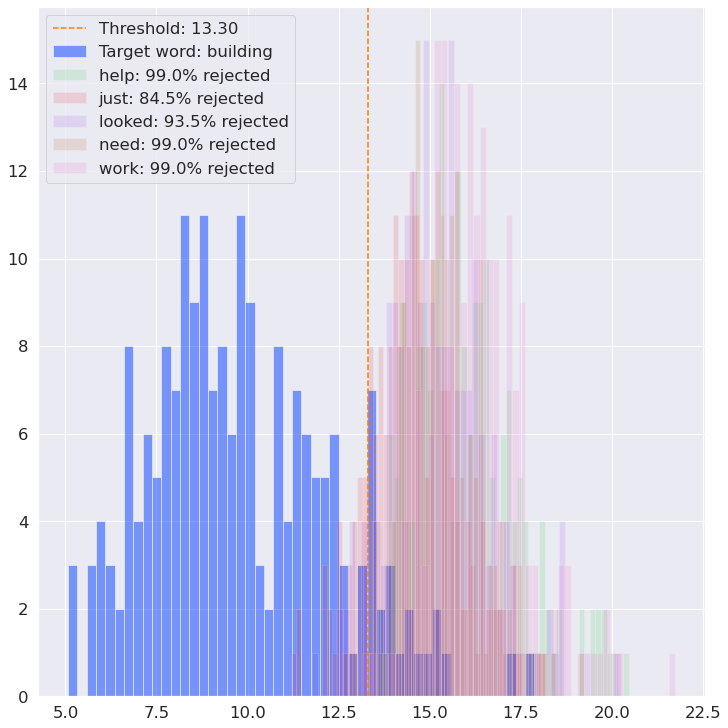

In [40]:
THRESH = 0.90
fig,ax= plt.subplots(constrained_layout=True)
target_embedding = to_embedding(candidate_target)
distances = np.linalg.norm(to_embeddings_vectorized(samples) - target_embedding, axis=1)
threshold = np.quantile(distances, THRESH)
non_target_words = ["help", "just", "looked", "need", "work"]
#non_target_words = non_target_words[:4]
# target distance distribution
ax.hist(distances, bins=50, alpha=0.5, label=f"Target word: {candidate_word}", color=sns.color_palette("bright")[0]);
# target threshold
ax.axvline(x=threshold, label=f"Threshold: {threshold:.2f}", linestyle="--", color=sns.color_palette("bright")[1])

for jx, w in enumerate(non_target_words):
    non_target_distances, correct_rejected_pct = ds[w]
    ax.hist(non_target_distances, bins=50, alpha=0.125, label=f"{w}: {correct_rejected_pct:.1f}% rejected", color=sns.color_palette("bright")[jx + 2]);        
    
ax.legend(loc='upper left');
ax.set_ylim((0.0, 15.75))
ax.set_xlim((4.238244533538818, 22.57118272781372))
fig.set_size_inches(10,10);

# few shot blind in aggregate

In [86]:
NUM_SAMPLES=200
THRESH = 0.9
NON_TARGET_WORDS = 5
FEW_SHOT = 5

NUM_WORDS =30

rejections = {}

candidate_words = np.random.choice(other_words, NUM_WORDS, replace=False)
for ix,candidate_word in enumerate(candidate_words):
    print(candidate_word)
    
    candidates = glob.glob(f"{data_dir}{candidate_word}/*.wav")
    samples = np.random.choice(candidates, NUM_SAMPLES + FEW_SHOT, replace=False)

    targets = samples[:FEW_SHOT]
    additional_samples = samples[FEW_SHOT:]

    target_embeddings = to_embeddings_vectorized(targets) 
    distances = vectorized_min_distances_to_few_shot_embeddings(target_embeddings, additional_samples)
    
    threshold = np.quantile(distances, THRESH)
    
    non_target_words = np.random.choice(other_words, NON_TARGET_WORDS + 1, replace=False)
    non_target_words = [w for w in non_target_words if w != candidate_word][:NON_TARGET_WORDS]

    correct_rejected_pcts={}
    
    for jx, w in enumerate(non_target_words):
        non_target_candidates = glob.glob(f"{data_dir}{w}/*.wav")
        non_target_samples = np.random.choice(non_target_candidates, NUM_SAMPLES, replace=False)
        non_target_distances = vectorized_min_distances_to_few_shot_embeddings(target_embeddings, non_target_samples)
        
        correct_rejected_pct = (non_target_distances[non_target_distances > threshold].shape[0] / NUM_SAMPLES) * 100
        
        correct_rejected_pcts[w] = correct_rejected_pct
    
    rejections[candidate_word] = (correct_rejected_pcts,threshold)

early
house
would
also
building
give
east
state
wind
other
make
alchemist
written
children
tell
several
looked
heart
many
group
known
include
knew
county
own
large
name
show
very
will


In [87]:
len(rejections.keys())

30

In [104]:
raise ValueError("caution overwrites")
with open("rejections_fewshot_30words.pkl", 'wb') as fh:
    pickle.dump(rejections, fh, protocol=pickle.HIGHEST_PROTOCOL)

In [89]:
report=[]
for target, kw_rejections_thresh in rejections.items():
    rejections_for_target, threshold = kw_rejections_thresh
    rs = list(rejections_for_target.values())
    report.append([target, np.mean(rs), np.std(rs), threshold])
df = pd.DataFrame(report, columns=["target", "mean_rejections", "std_rejections", "thresh"])
df

,target,mean_rejections,std_rejections,thresh
0,early,98.0,2.302173,10.958487
1,house,85.5,16.309506,9.687580
2,would,86.7,9.795918,10.270464
3,also,55.7,32.538592,11.547779
4,building,85.3,23.517228,10.618681
5,give,75.5,16.625282,9.047707
6,east,91.9,9.748846,7.982948
7,state,93.9,11.951569,8.044913
8,wind,91.4,6.711185,8.475765
9,other,84.5,13.084342,8.972158


In [100]:
summary = {"Mean threshold": df.thresh.mean(), "Threshold stdev": df.thresh.std(), "Mean of rejected means": df.mean_rejections.mean(), "Mean of rejected stdev": df.std_rejections.mean()}
s = pd.DataFrame.from_dict(summary,orient="index")
s

,0
Mean threshold,9.648537
Threshold stdev,1.179177
Mean of rejected means,79.716667
Mean of rejected stdev,13.470624


In [103]:
print(s.to_latex(header=False, float_format="%.2f", label="tab:fewshot_summary", caption="Summary statisics for few-shot embeddings (n=5)"))

\begin{table}
\centering
\caption{Summary statisics for few-shot embeddings (n=5)}
\label{tab:fewshot_summary}
\begin{tabular}{lr}
\toprule
Mean threshold         &  9.65 \\
Threshold stdev        &  1.18 \\
Mean of rejected means & 79.72 \\
Mean of rejected stdev & 13.47 \\
\bottomrule
\end{tabular}
\end{table}



In [90]:
cap = "Successful rejections of non-target keywords for 30 randomly selected few-shot embeddings (n=5)"
print(df.to_latex(index=False, header=["Target","Mean % Rejected", "StDev % Rejected", "Threshold"], float_format="%.2f",caption=cap, label="tab:few"))

\begin{table}
\centering
\caption{Successful rejections of non-target keywords for 30 randomly selected few-shot embeddings (n=5)}
\label{tab:few}
\begin{tabular}{lrrr}
\toprule
    Target & Mean \% Rejected & StDev \% Rejected & Threshold \\
\midrule
     early &           98.00 &             2.30 &     10.96 \\
     house &           85.50 &            16.31 &      9.69 \\
     would &           86.70 &             9.80 &     10.27 \\
      also &           55.70 &            32.54 &     11.55 \\
  building &           85.30 &            23.52 &     10.62 \\
      give &           75.50 &            16.63 &      9.05 \\
      east &           91.90 &             9.75 &      7.98 \\
     state &           93.90 &            11.95 &      8.04 \\
      wind &           91.40 &             6.71 &      8.48 \\
     other &           84.50 &            13.08 &      8.97 \\
      make &           90.70 &             6.51 &      8.74 \\
 alchemist &           92.00 &             6.66 &      

# zero-shot blind in aggregate

In [107]:
NUM_EXPERIMENTS=30
NUM_SAMPLES=200
THRESH = 0.90
NON_TARGET_WORDS = 50

candidate_targets = np.random.choice(other_words, NUM_EXPERIMENTS, replace=False)

rejections = {}

for ix,candidate_word in enumerate(candidate_targets):
    
    print(candidate_word)
    candidates = glob.glob(f"{data_dir}{candidate_word}/*.wav")
    samples = np.random.choice(candidates, NUM_SAMPLES + 1, replace=False)
    
    candidate_target = samples[0]
    samples = samples[1:]

    target_embedding = to_embedding(candidate_target)
    distances = np.linalg.norm(to_embeddings_vectorized(samples) - target_embedding, axis=1)
    
    threshold = np.quantile(distances, THRESH)
    
    non_target_words = np.random.choice(other_words, NON_TARGET_WORDS + 1, replace=False)
    non_target_words = [w for w in non_target_words if w != candidate_word][:NON_TARGET_WORDS]
    
    correct_rejected_pcts = {}
    
    for jx, w in enumerate(non_target_words):
        non_target_candidates = glob.glob(f"{data_dir}{w}/*.wav")
        non_target_samples = np.random.choice(non_target_candidates, NUM_SAMPLES, replace=False)
        non_target_distances = np.linalg.norm(to_embeddings_vectorized(non_target_samples) - target_embedding, axis=1)
        
        correct_rejected_pct = (non_target_distances[non_target_distances > threshold].shape[0] / NUM_SAMPLES) * 100
        
        correct_rejected_pcts[w] = correct_rejected_pct
        
    rejections[candidate_word] = (correct_rejected_pcts,threshold)

street
well
today
back
show
thing
also
over
would
sun
east
man
being
last
local
group
make
knew
then
many
wanted
become
south
state
englishman
about
where
does
same
always


In [52]:
# old format, only rejections
# raise ValueError("caution overwrites")
# with open("rejections_20words.pkl", 'wb') as fh:
#     pickle.dump(rejections, fh, protocol=pickle.HIGHEST_PROTOCOL)

In [108]:
raise ValueError("caution overwrites")
with open("rejections_zeroshot_30words.pkl", 'wb') as fh:
    pickle.dump(rejections, fh, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open("rejections_zeroshot_30words.pkl", 'rb') as fh:
    rejections = pickle.load(fh)

In [109]:
report=[]
for target, kw_rejections_thresh in rejections.items():
    rejections_for_target, threshold = kw_rejections_thresh
    rs = list(rejections_for_target.values())
    report.append([target, np.mean(rs), np.std(rs), threshold])

In [110]:
report

[['street', 11.03, 11.682640968548165, 13.38502311706543],
 ['well', 56.28, 27.514025514271808, 10.912375450134277],
 ['today', 28.41, 19.788302099978157, 12.667446422576905],
 ['back', 88.12, 13.416616563053445, 10.087856101989747],
 ['show', 99.09, 3.0605391681858936, 9.887001419067383],
 ['thing', 72.95, 20.767582911836417, 11.143559837341309],
 ['also', 91.68, 11.139910233031504, 12.148353481292723],
 ['over', 53.02, 20.21162041994654, 12.635183906555175],
 ['would', 74.28, 19.3072939585018, 11.811987590789794],
 ['sun', 95.01, 10.442935411080546, 8.97276659011841],
 ['east', 98.16, 4.009289213813342, 9.326526927947999],
 ['man', 95.39, 11.470523091821052, 12.279166316986084],
 ['being', 89.23, 12.643263028190152, 11.985814666748047],
 ['last', 50.59, 24.31104481506297, 13.021384811401367],
 ['local', 40.08, 25.357121287717185, 11.72308177947998],
 ['group', 55.81, 25.00397768356067, 11.653541660308838],
 ['make', 89.74, 15.207971593871418, 10.689146327972413],
 ['knew', 60.7, 24.1

In [111]:
# report = {}
# for target, kw_rejections in rejections.items():
#     avg_rejections_for_target = np.mean(list(kw_rejections.values()))
#     report[target]=avg_rejections_for_target

#df = pd.DataFrame.from_dict(report, orient='index', columns=['mean_pct_rejected'])    
df = pd.DataFrame(report, columns=["target", "mean_rejections", "std_rejections", "thresh"])

#df.loc['Mean of means'] = df.mean()
#df

#df.loc[len(df)] = ["Mean of means", df["mean_rejections"].mean(), df["std_rejections"].mean(), (df["thresh"].mean(),df["thresh"].std())]
df

,target,mean_rejections,std_rejections,thresh
0,street,11.03,11.682641,13.385023
1,well,56.28,27.514026,10.912375
2,today,28.41,19.788302,12.667446
3,back,88.12,13.416617,10.087856
4,show,99.09,3.060539,9.887001
5,thing,72.95,20.767583,11.143560
6,also,91.68,11.139910,12.148353
7,over,53.02,20.211620,12.635184
8,would,74.28,19.307294,11.811988
9,sun,95.01,10.442935,8.972767


In [112]:
cap = "Successful rejections of non-target keywords for 30 randomly selected zero-shot embeddings"
print(df.to_latex(index=False, header=["Target","Mean % Rejected", "StDev % Rejected", "Threshold"], float_format="%.2f",caption=cap, label="tab:zero"))

\begin{table}
\centering
\caption{Successful rejections of non-target keywords for 30 randomly selected zero-shot embeddings}
\label{tab:zero}
\begin{tabular}{lrrr}
\toprule
     Target & Mean \% Rejected & StDev \% Rejected & Threshold \\
\midrule
     street &           11.03 &            11.68 &     13.39 \\
       well &           56.28 &            27.51 &     10.91 \\
      today &           28.41 &            19.79 &     12.67 \\
       back &           88.12 &            13.42 &     10.09 \\
       show &           99.09 &             3.06 &      9.89 \\
      thing &           72.95 &            20.77 &     11.14 \\
       also &           91.68 &            11.14 &     12.15 \\
       over &           53.02 &            20.21 &     12.64 \\
      would &           74.28 &            19.31 &     11.81 \\
        sun &           95.01 &            10.44 &      8.97 \\
       east &           98.16 &             4.01 &      9.33 \\
        man &           95.39 &            11.4

In [115]:
summary = {"Mean threshold": df.thresh.mean(), "Threshold stdev": df.thresh.std(), "Mean of rejected means": df.mean_rejections.mean(), "Mean of rejected stdev": df.std_rejections.mean()}
s = pd.DataFrame.from_dict(summary,orient="index")
print(s.to_latex(header=False, float_format="%.2f", label="tab:zeroshot_summary", caption="Summary statisics for 30 zero-shot embeddings"))

\begin{table}
\centering
\caption{Summary statisics for 30 zero-shot embeddings}
\label{tab:zeroshot_summary}
\begin{tabular}{lr}
\toprule
Mean threshold         & 11.55 \\
Threshold stdev        &  1.33 \\
Mean of rejected means & 68.36 \\
Mean of rejected stdev & 17.75 \\
\bottomrule
\end{tabular}
\end{table}



In [26]:
np.mean([53.45,57.87])

55.66

# transfer learning experiments 

In [116]:
data_dir = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/"
os.chdir("/home/mark/tinyspeech_harvard/train_100_augment/")
with open("wordlist.txt", "r") as fh:
    commands = fh.read().splitlines()
with open("files.txt", "r") as fh:
    files = fh.read().splitlines()    
    
ten_pct = int(0.1 * len(files))
train_split = ten_pct * 8 
val_split = train_split + ten_pct

train_files = files[:train_split]
val_files = files[train_split:val_split]
test_files = files[val_split:]

print(len(train_files), len(val_files), len(test_files))    
model_settings = input_data.prepare_model_settings(
        label_count=100,
        sample_rate=16000,
        clip_duration_ms=1000,
        window_size_ms=30,
        window_stride_ms=20,
        feature_bin_count=40,
        preprocess="micro",
    )
bg_datadir = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/_background_noise_/"

a = input_data.AudioDataset(model_settings, commands, bg_datadir, [], unknown_percentage=0)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = a.init(AUTOTUNE, train_files, is_training=True)
val_ds = a.init(AUTOTUNE, val_files, is_training=False)
test_ds = a.init(AUTOTUNE, test_files, is_training=False)
batch_size = 64
train_ds = train_ds.shuffle(buffer_size=4000).batch(batch_size)
val_ds = val_ds.batch(batch_size)

160000 20000 20000


In [117]:
model = tf.keras.models.load_model("./hundredword_resnet_2k_selu.48-0.87")

#penultimate = tf.keras.Model(inputs=model.inputs, outputs=model.get_layer("dense_21").output)

In [271]:
test_audio = []
test_labels = []

for ix,(audio, label) in enumerate(test_ds):
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())
    if ix % 6000 == 0:
        print(ix)
    #if ix > 8000:
    #    break

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

0
6000
12000
18000
Test set accuracy: 87%


In [118]:
other_words = [w for w in os.listdir(data_dir) if w != "_background_noise_" and w not in commands]
other_words.sort()
print(len(other_words))
assert(len(set(other_words).intersection(commands))==0)

165


In [273]:
" ".join(commands)

'night only say take blue how ever mind morning family than please nothing next different up went good main station little might right hand eyes film black use book air never district know gold already girl party yes better some game through way born those them three saw four heard one king father men something boy each school park during go things first seen road again second should number love time off red done now thought read told which played company old like world answered been music year fire found seven away everything here more town put both who often'

In [274]:
" " .join(other_words)

'about after album alchemist also always another anything appeared area around asked back based became because become before began being best between building built called children city college continued could county day days decided desert does down early earth east eight end englishman even every everyone few find five friend get give going great green group heart help high home house however idea include into just knew known language large last later left life light live local located long look looked looking lot made make man many matter mean money most much must name named national near need new nine north office once other over own part people place play playing point public really river same see served set several sheep show since six small son sound south state still street such sun system team tell then these thing think times today took under united university used very want wanted war water well west when where will wind without woman work would written years young'

In [119]:
np.random.choice(other_words, 5, replace=False)

array(['decided', 'everyone', 'after', 'desert', 'point'], dtype='<U10')

In [276]:
fiveword_xfer = ['street', 'idea', 'lot', 'being', 'before']

In [62]:
fiveword_xfer = ['decided', 'everyone', 'after', 'desert', 'point']

In [121]:
for w in fiveword_xfer:
    print(w in commands)

False
False
False
False
False


In [122]:
for w in fiveword_xfer:
    wavs = glob.glob(data_dir + w + "/*.wav")
    print(len(wavs))

2902
3287
15488
5009
3389


In [133]:
mini_dataset = {}
mini_val = {}

N_UTTERANCES = 5
VAL_UTTERANCES = 400

for w in fiveword_xfer:
    wavs = glob.glob(data_dir + w + "/*.wav")
    selected = np.random.choice(wavs, N_UTTERANCES + VAL_UTTERANCES, replace=False)
    
    mini_dataset[w] = selected[:N_UTTERANCES]
    mini_val[w] = selected[N_UTTERANCES:]

In [ ]:
model.summary()

In [149]:
# https://github.com/tensorflow/tfjs-models/blob/master/speech-commands/training/browser-fft/training_custom_audio_model_in_python.ipynb
#xfer = tf.keras.Sequential(name="TransferLearnedModel")
#for layer in model.layers[:-1]:
#    xfer.add(layer)
#xfer = tf.keras.models.clone_model(model)
#xfer.layers.pop()
#xfer.add(tf.keras.layers.Dense(units=5, activation="softmax"))   

# Freeze all but the last layer of the model. The last layer will be fine-tuned
# during transfer learning.
#for layer in xfer.layers[:-1]:
#    xfer.trainable = False

xfer = tf.keras.models.Model(name="TransferLearnedModel", inputs=model.inputs, outputs=model.get_layer(name="dense_21").output)
xfer.trainable = False

# dont use softmax unless losses from_logits=False
xfer = tf.keras.models.Sequential([xfer, tf.keras.layers.Dense(units=6, activation='softmax')]) # 5 words + silence
    
xfer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [135]:
train_files = [f for d in mini_dataset.values() for f in d]
len(train_files)

25

In [136]:
val_files = [f for d in mini_val.values() for f in d]
len(val_files)

2000

In [137]:
np.random.shuffle(train_files)

In [138]:
train_files[:5]

['/home/mark/tinyspeech_harvard/frequent_words/en/clips/after/common_voice_en_120943.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/desert/common_voice_en_603106.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/decided/common_voice_en_599586.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/after/common_voice_en_654238.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/desert/common_voice_en_191825.wav']

In [139]:
model_settings = input_data.prepare_model_settings(
        label_count=100,
        sample_rate=16000,
        clip_duration_ms=1000,
        window_size_ms=30,
        window_stride_ms=20,
        feature_bin_count=40,
        preprocess="micro",
    )
bg_datadir = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/_background_noise_/"

a = input_data.AudioDataset(model_settings, fiveword_xfer, bg_datadir, unknown_words=[], unknown_percentage=0)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = a.init(AUTOTUNE, train_files, is_training=True)
val_ds = a.init(AUTOTUNE, val_files, is_training=False)
#test_ds = a.init(AUTOTUNE, test_files, is_training=False)
batch_size = 64
train_ds = train_ds.shuffle(buffer_size=4000).batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [140]:
a.commands

<tf.Tensor: shape=(6,), dtype=string, numpy=
array([b'_silence_', b'decided', b'everyone', b'after', b'desert',
       b'point'], dtype=object)>

In [150]:
EPOCHS = 200
history = xfer.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
)

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 2.8652 - accuracy: 0.0400 - val_loss: 2.4902 - val_accuracy: 0.1250
Epoch 2/200
1/1 [==============================] - 0s 474ms/step - loss: 2.4633 - accuracy: 0.0800 - val_loss: 2.4405 - val_accuracy: 0.1320
Epoch 3/200
1/1 [==============================] - 0s 467ms/step - loss: 2.5777 - accuracy: 0.1600 - val_loss: 2.3910 - val_accuracy: 0.1435
Epoch 4/200
1/1 [==============================] - 0s 475ms/step - loss: 2.4036 - accuracy: 0.1200 - val_loss: 2.3432 - val_accuracy: 0.1535
Epoch 5/200
1/1 [==============================] - 0s 479ms/step - loss: 2.5303 - accuracy: 0.0800 - val_loss: 2.2953 - val_accuracy: 0.1630
Epoch 6/200
1/1 [==============================] - 0s 487ms/step - loss: 2.3998 - accuracy: 0.2000 - val_loss: 2.2484 - val_accuracy: 0.1720
Epoch 7/200
1/1 [==============================] - 0s 475ms/step - loss: 2.6319 - accuracy: 0.1200 - val_loss: 2.2029 - val_accuracy: 0.1845
Epoch 8/200
1/1 

In [151]:
ws = "_".join(fiveword_xfer)
name = f"xfer_fiveword_{EPOCHS}_epochs_{ws}"
print(name)
xfer.save(name)

xfer_fiveword_200_epochs_decided_everyone_after_desert_point
INFO:tensorflow:Assets written to: xfer_fiveword_200_epochs_decided_everyone_after_desert_point/assets


In [60]:
xfer = tf.keras.models.load_model("./xfer_fiveword_200_epochs_decided_everyone_after_desert_point")

groundtruth point /home/mark/tinyspeech_harvard/frequent_words/en/clips/point/common_voice_en_26178.wav
prediction point 0.97137266


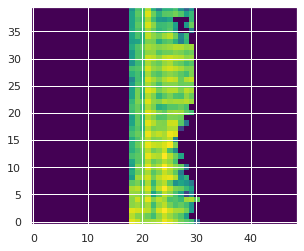

In [166]:
word = np.random.choice(fiveword_xfer)

f = np.random.choice(glob.glob(data_dir + word + "/*.wav"))

print("groundtruth", word, f)
spec = a.file2spec(f)

plt.imshow(spec.numpy().T, origin="lower", cmap="viridis");

pred = xfer.predict(spec.numpy().reshape(1,49,40,1))
p = np.argmax(pred)
print("prediction", a.commands[p].numpy().decode('utf8'), pred[0][p])

_,wav = wavfile.read(f)
ipd.Audio(wav,rate=16000, autoplay=True)

In [63]:
unknown_other_words = set(other_words).difference(set(fiveword_xfer))
unknown_command_words = set(commands)

groundtruth eight /home/mark/tinyspeech_harvard/frequent_words/en/clips/eight/common_voice_en_22118966.wav
prediction point 0.9403835


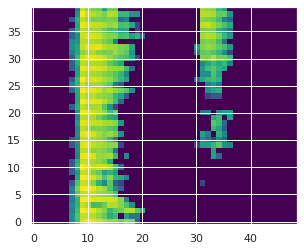

In [179]:
word = np.random.choice(list(unknown_other_words))

f = np.random.choice(glob.glob(data_dir + word + "/*.wav"))

print("groundtruth", word, f)
spec = a.file2spec(f)

plt.imshow(spec.numpy().T, origin="lower", cmap="viridis");

pred = xfer.predict(spec.numpy().reshape(1,49,40,1))
p = np.argmax(pred)
print("prediction", a.commands[p].numpy().decode('utf8'), pred[0][p])

_,wav = wavfile.read(f)
ipd.Audio(wav,rate=16000, autoplay=True)

In [64]:
correct_confidences = []
incorrect_confidences = []

NUM_SAMPLES = 1000

for ix, word in enumerate(fiveword_xfer):
    label_id = ix+1
    print(word, label_id)

    samples = np.random.choice(glob.glob(data_dir + word + "/*.wav"),NUM_SAMPLES, replace=False)
    specs = np.array([a.file2spec(f) for f in samples])
    preds = xfer.predict(np.expand_dims(specs,-1))
    cols = np.argmax(preds,axis=1)
    
    # figure out how to fancy-index this later
    for row,col in enumerate(cols):
        confidence = preds[row][col]
        if col == label_id:
            correct_confidences.append(confidence)
        else:
            incorrect_confidences.append(confidence)

decided 1
everyone 2
after 3
desert 4
point 5


In [245]:
200 * 50


10000

In [247]:
len(correct_confidences)

4201

In [248]:
len(incorrect_confidences)

799

In [251]:
sns.set(font_scale=1.2)

In [65]:
n_words = 50
n_examples = 200

unknown_confidences = []

uws = np.random.choice(list(unknown_other_words), n_words, replace=False)
for ix,word in enumerate(uws):
    fs = np.random.choice(glob.glob(data_dir + word + "/*.wav"), n_examples, replace=False)

    specs = np.array([a.file2spec(f) for f in fs])
    preds = xfer.predict(np.expand_dims(specs,-1))
    
    softmaxes = np.max(preds,axis=1)
    unknown_confidences.extend(softmaxes.tolist())

In [87]:
ucs = np.array(unknown_confidences)

In [88]:
ucs.shape

(10000,)

In [90]:
ucs[ucs < 0.9].shape

(9274,)

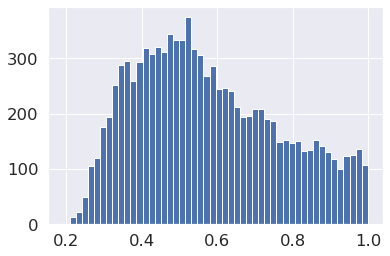

In [66]:
plt.hist(unknown_confidences,bins=50);

In [72]:

ax.get_xlim(), ax.get_ylim()

((0.15297293961048125, 1.0402733653783798), (0.0, 466.2))

In [77]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

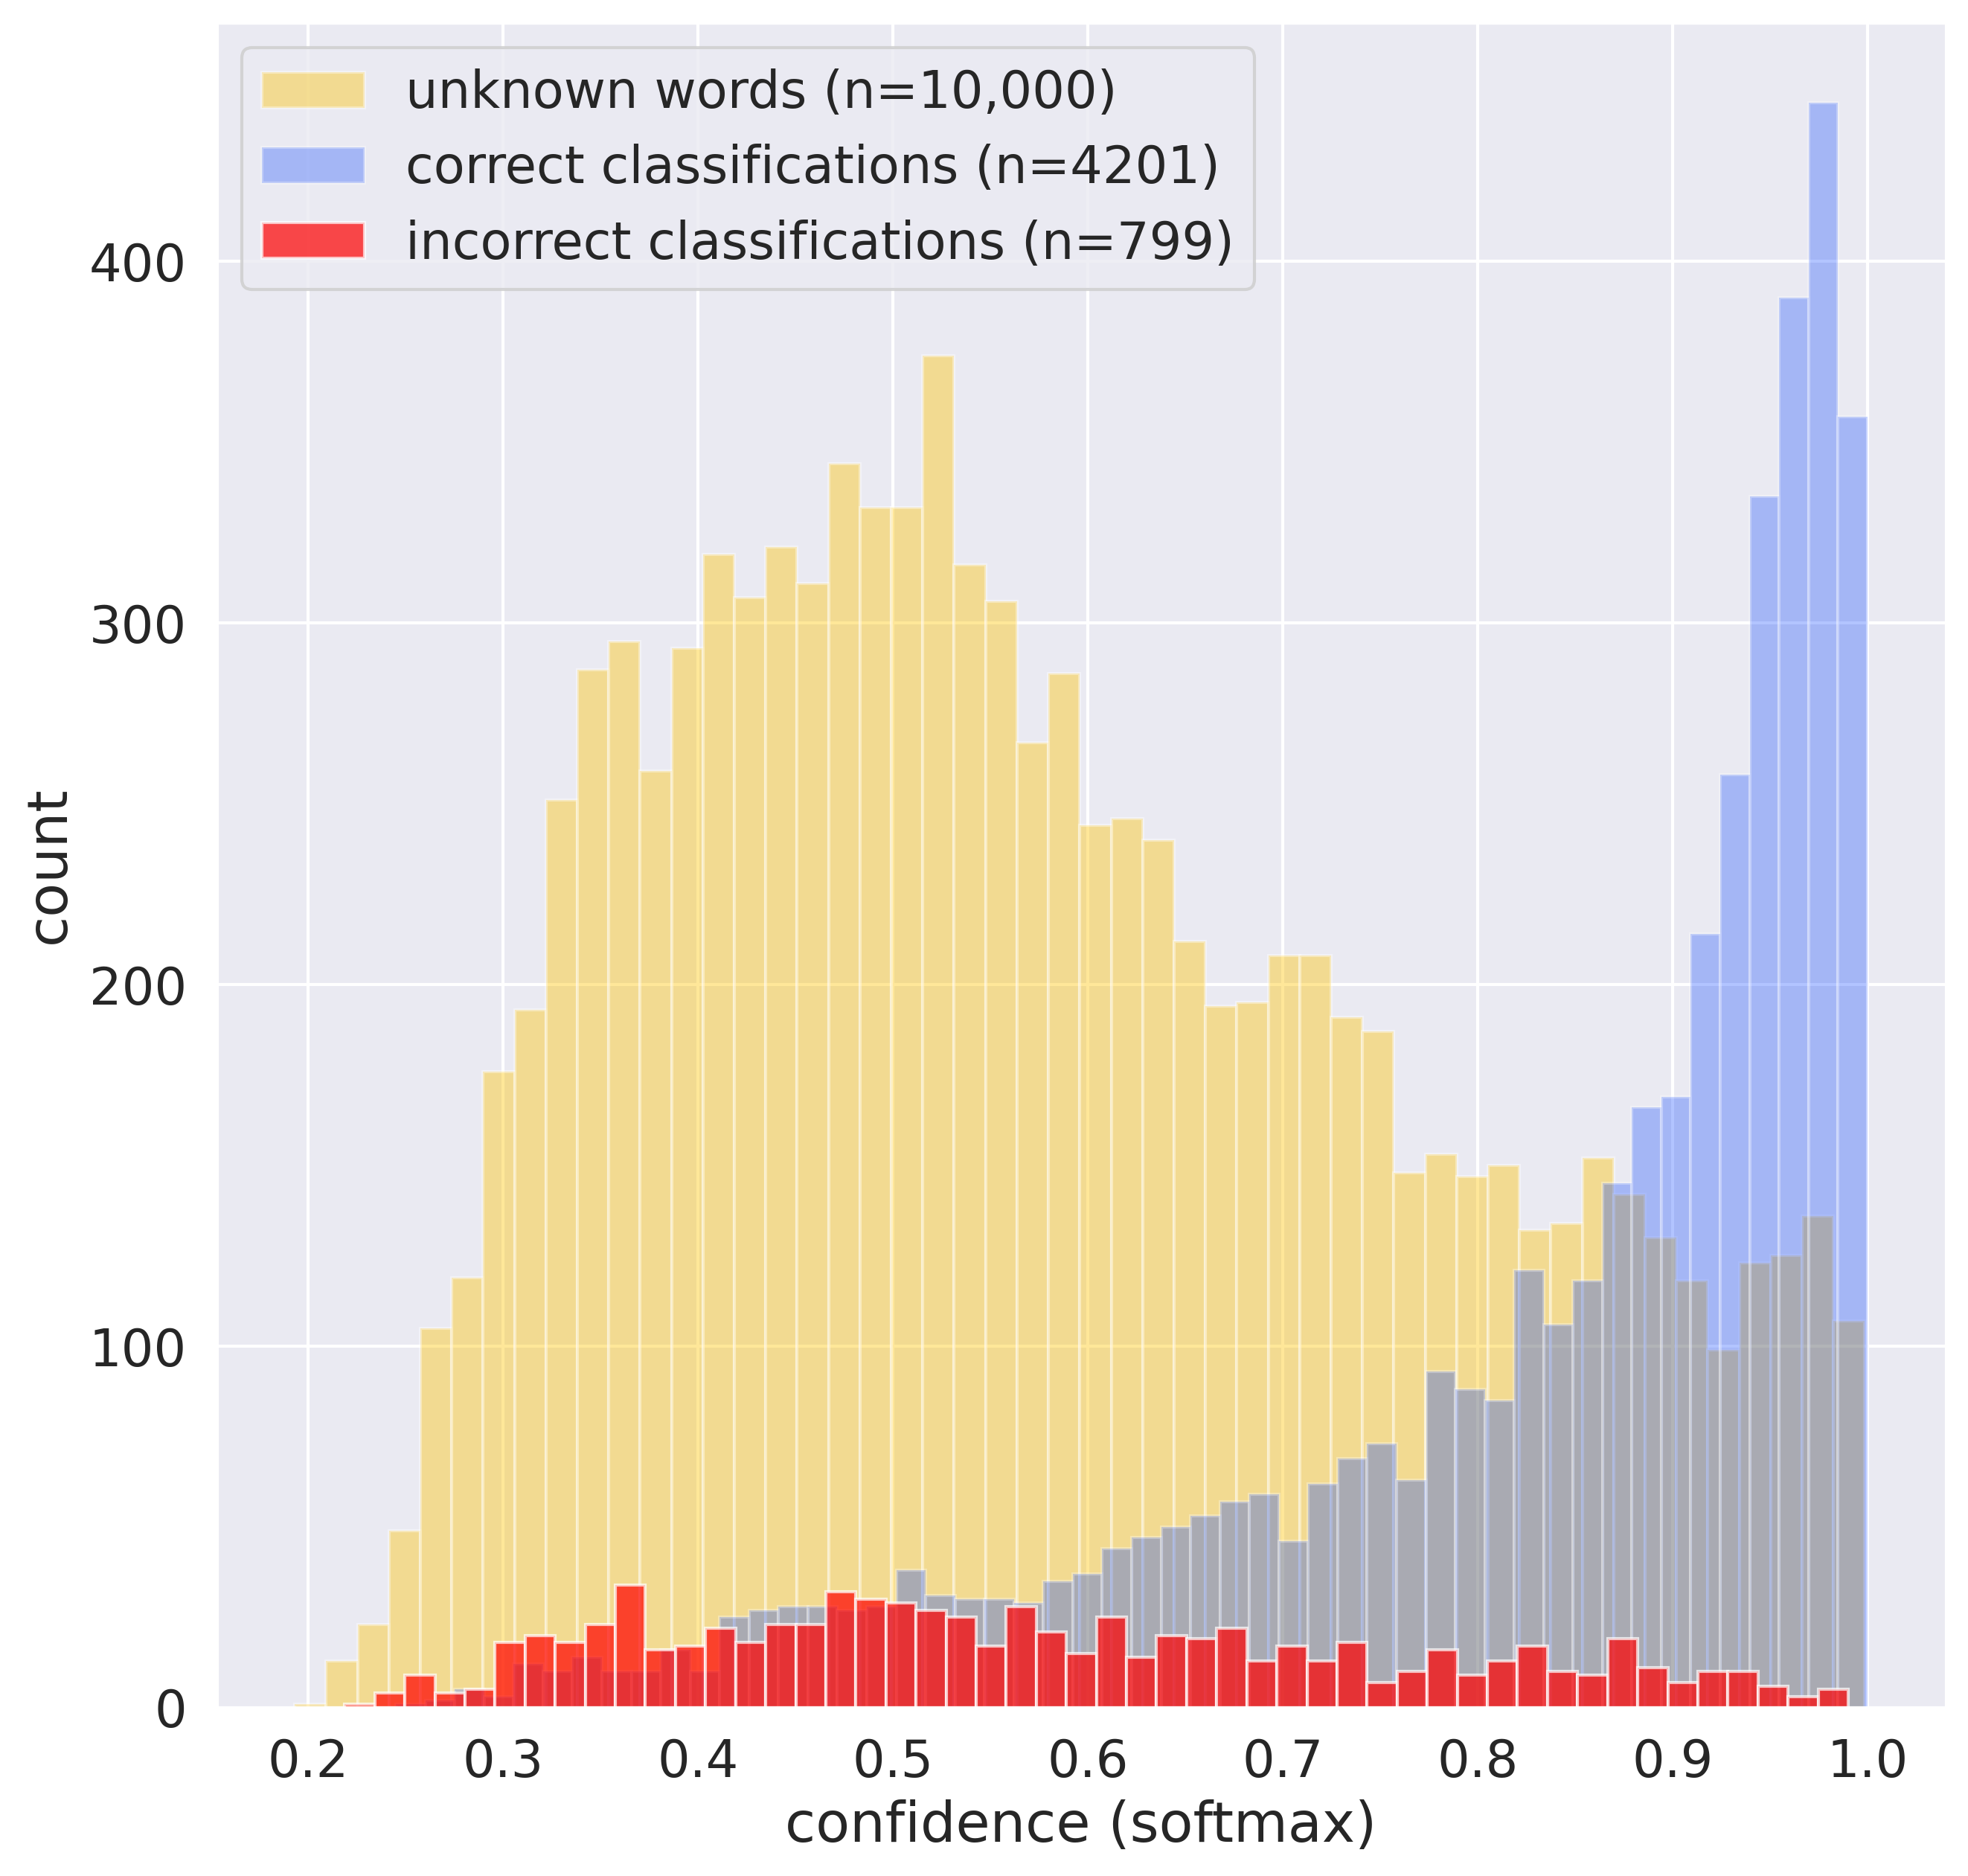

In [80]:
fig,ax=plt.subplots()
ax.hist(unknown_confidences,bins=50,alpha=.4, label="unknown words (n=10,000)", color=sns.color_palette("bright")[8])
ax.hist(correct_confidences,bins=50,alpha=.3, label='correct classifications (n=4201)', color=sns.color_palette("bright")[0])
ax.hist(incorrect_confidences,bins=50,alpha=.7, label="incorrect classifications (n=799)", color='red')

ax.legend(loc='upper left');
ax.set_xlabel("confidence (softmax)")
ax.set_ylabel("count")
ax.set_xlim((0.15297293961048125, 1.0402733653783798))
ax.set_ylim((0.0, 466.2))
fig.set_size_inches(10,10);

(array([ 1.,  3.,  3.,  9.,  9., 10., 14., 18., 42., 91.]),
 array([0.3624159 , 0.42569524, 0.48897457, 0.5522539 , 0.61553323,
        0.6788125 , 0.74209183, 0.80537117, 0.8686505 , 0.9319298 ,
        0.99520916], dtype=float32),
 <BarContainer object of 10 artists>)

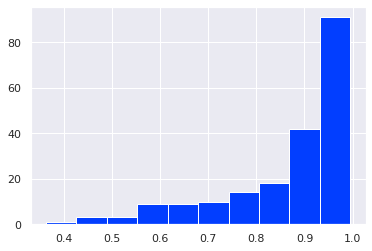

In [196]:
# figure out how to fancy-index this later
confs = []
for ix,p in enumerate(ps):
    confs.append(preds[ix][p])
plt.hist(confs)

In [187]:
preds[0]

array([0.0025399 , 0.01036762, 0.96945524, 0.00408008, 0.00613686,
       0.00742025], dtype=float32)

In [189]:
np.argmax(preds,axis=1)[0]

2

In [180]:
confidences = []
for ix in range(1000):
    if ix % 100 == 0:
        print(ix)
    word = np.random.choice(list(unknown_other_words))

    f = np.random.choice(glob.glob(data_dir + word + "/*.wav"))

    spec = a.file2spec(f)
    pred = xfer.predict(spec.numpy().reshape(1,49,40,1))
    p = np.argmax(pred)
    #print("prediction", a.commands[p].numpy().decode('utf8'), pred[0][p])
    confidences.append(pred[0][p])

0
100
200
300
400
500
600
700
800
900


(array([ 43., 131., 146., 144., 128.,  87., 100.,  87.,  71.,  63.]),
 array([0.22563449, 0.30300614, 0.3803778 , 0.45774946, 0.53512114,
        0.6124928 , 0.68986446, 0.7672361 , 0.8446078 , 0.9219794 ,
        0.9993511 ], dtype=float32),
 <BarContainer object of 10 artists>)

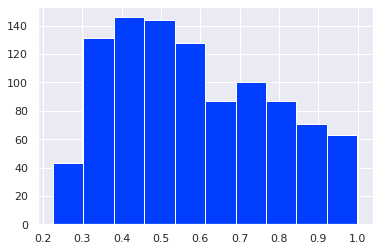

In [181]:
plt.hist(confidences)

In [349]:
len(train_files)

100

In [350]:
fiveword_xfer

['street', 'idea', 'lot', 'being', 'before']

In [351]:
len(val_files)

1900